In [8]:
import numpy as np
import rasterio
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import os

In [9]:
pre_path  = r"C:\Users\admin\OneDrive - IIRS\Desktop\imagery analyst\S1\subset_0_of_S1A_IW_GRDH_1SDV_20210615T001158_20210615T001223_038343_048668_EA52_Orb_Cal_ML_TC.tif"
post_path = r"C:\Users\admin\OneDrive - IIRS\Desktop\imagery analyst\S1\subset_0_of_S1A_IW_GRDH_1SDV_20210709T001200_20210709T001225_038693_0490E6_BF44_Orb_Cal_ML_TC.tif"
out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

eps = 1e-6

In [10]:
with rasterio.open(pre_path) as src:
    pre = src.read(1).astype('float32')
    profile = src.profile.copy()

with rasterio.open(post_path) as src:
    post = src.read(1).astype('float32')

In [11]:
minr = min(pre.shape[0], post.shape[0])
minc = min(pre.shape[1], post.shape[1])
pre = pre[:minr,:minc]
post = post[:minr,:minc]
profile.update({'height': minr, 'width': minc, 'count': 1, 'dtype': 'float32'})

In [12]:
logratio = 10.0 * np.log10((post + eps) / (pre + eps))
logratio_s = median_filter(logratio, size=3)

In [14]:
from skimage.filters import threshold_otsu

In [15]:
vals = logratio_s[np.isfinite(logratio_s)]
th = threshold_otsu(np.abs(vals)) if vals.size>0 else 2.0
if th < 0.5: th = 0.5
if th > 5.0: th = 5.0

mask = (np.abs(logratio_s) > th).astype('uint8')

In [17]:
def quicklook(arr, scale=8):
    h, w = arr.shape
    arr_small = arr[::scale, ::scale]
    return arr_small

In [27]:
lr_small = quicklook(mask, scale=8)



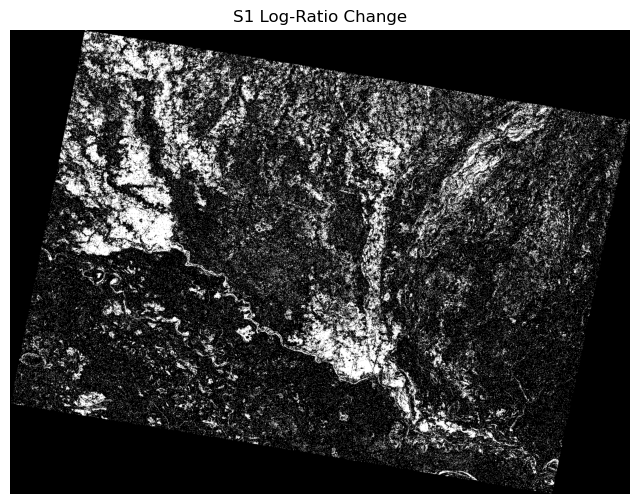

In [30]:
plt.figure(figsize=(8,8))
plt.imshow(lr_small, cmap='gray')
plt.axis('off')
plt.title("S1 Log-Ratio Change")
plt.savefig("S1_change_logratio.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
profile.update({'dtype': 'uint8'})
out_mask = os.path.join(out_dir, "s1_change_mask_VV.tif")
with rasterio.open(out_mask, 'w', **profile) as dst:
    dst.write(mask, 1)